In [2]:
import os
import matplotlib.pyplot as plt
import sklearn
import pandas as pd
import numpy as np
from scipy.stats import zscore
from scipy.stats import pearsonr
from scipy.stats import ttest_ind
import xgboost as xgb
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm
import statsmodels.formula.api as smf
import seaborn as sns
from sklearn.cross_decomposition import PLSRegression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import explained_variance_score
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import zscore
import glob
import shap
import scipy

In [3]:
pd.set_option('display.max_rows', None)

In [4]:
def areaUnderCurve(a, b):
    total = 0
    temp = 0
    for i in range(len(a)-1):
        if (b[i+1]-b[0]>=0) and (b[i]-b[0]>=0):
            temp = ((b[i]-b[0]+b[i+1]-b[0])/2)*(a[i+1]-a[i])
        elif (b[i+1]-b[0] < 0) and (b[i]-b[0] >= 0):
            temp = (b[i]-b[0])*((b[i]-b[0])/(b[i]-b[i+1])*(a[i+1]-a[i])/2)
        elif (b[i+1]-b[0] >= 0) and (b[i]-b[0] < 0):
            temp = (b[i+1]-b[0])*((b[i+1]-b[0])/(b[i+1]-b[i])*(a[i+1]-a[i])/2)
        elif (b[i]-b[0] < 0) and (b[i+1]-b[0] < 0):
            temp = 0
        total = total + temp
    return total

def calc_iauc(cgm, sampling_interval):
    a = []
    for i in range(len(cgm)):
        a.append(i * sampling_interval[i])
    return areaUnderCurve(a, cgm)

def calc_auc(cgm, sampling_interval):
    return np.trapz(cgm, dx=sampling_interval)

In [5]:
data_all_sub = pd.DataFrame(columns = ["sub", "Libre GL", "Carb", "Protein", "Fat", "Fiber"])

hours = 2
libre_samples = hours * 4 + 1

for sub in sorted(os.listdir(".")):
    if sub[:8] != "CGMacros":
        continue
    data = pd.read_csv(os.path.join(sub, sub+'.csv'))
    # print(data)
    data_sub = pd.DataFrame(columns = ["sub", "Libre GL", "Carb", "Protein", "Fat", "Fiber"])    
    for index in data[(data["Meal Type"] == "Breakfast") | (data["Meal Type"] == "breakfast")].index:
        data_meal = {}
        data_meal["sub"] = sub[-3:]
        data_meal["Libre GL"] = data["Libre GL"][index:index+135:15].to_list()
        if len(data_meal["Libre GL"]) < 9:
            continue
        data_meal["iAUC"] = calc_iauc(data_meal["Libre GL"], [15 for i in range(libre_samples)])
        data_meal["AUC"] = calc_auc(data_meal["Libre GL"], 15)
        data_meal["Carb"] = data["Carbs"][index] * 4
        data_meal["Protein"] = data["Protein"][index] * 4
        data_meal["Fat"] = data["Fat"][index] * 9
        data_meal["Fiber"] = data["Fiber"][index] * 2
        data_meal["Calories"] = data["Calories"][index]
        data_sub = pd.concat([data_sub, pd.DataFrame([data_meal])], ignore_index=True)
    if data_sub["Carb"].iloc[0] == 24 and data_sub["Protein"].iloc[0] == 22 and data_sub["Fat"].iloc[0] == 10.5 and data_sub["Fiber"].iloc[0] == 0.0:
        data_sub = data_sub.iloc[1:]
    data_all_sub = pd.concat([data_all_sub, data_sub], ignore_index=True)
print(data_all_sub)

C:\Users\Hal\AppData\Local\Temp\ipykernel_23540\418343348.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_sub = pd.concat([data_sub, pd.DataFrame([data_meal])], ignore_index=True)
C:\Users\Hal\AppData\Local\Temp\ipykernel_23540\418343348.py:28: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_all_sub = pd.concat([data_all_sub, data_sub], ignore_index=True)
C:\Users\Hal\AppData\Local\Temp\ipykernel_23540\418343348.py:25: FutureWarning: The behavior of DataFrame concatenation with empt

     sub                                           Libre GL   Carb  Protein  \
0    001  [88.4, 98.0, 114.8, 114.0, 96.8, 93.8, 100.4, ...  264.0     88.0   
1    001  [86.26666666666667, 96.53333333333332, 104.466...  264.0    264.0   
2    001  [88.0, 90.4, 107.73333333333332, 117.0, 102.13...  264.0     88.0   
3    001  [90.66666666666669, 90.33333333333331, 97.2, 1...  292.0    264.0   
4    001  [94.2, 100.4, 105.2, 98.2, 87.6, 84.0, 85.8, 8...   96.0     88.0   
5    001  [95.46666666666668, 100.2, 109.66666666666669,...  264.0     88.0   
6    001  [100.66666666666669, 108.93333333333334, 97.0,...  264.0    264.0   
7    001  [91.0, 92.33333333333331, 98.66666666666669, 1...  264.0     88.0   
8    001  [84.0, 91.2, 102.6, 99.4, 90.0, 89.6, 87.6, 83...   96.0     88.0   
9    001  [89.13333333333334, 89.0, 94.2, 103.6666666666...  292.0     88.0   
10   002  [73.2, 77.6, 93.6, 109.0, 112.6, 105.0, 97.8, ...  264.0     88.0   
11   002  [76.4, 82.6, 99.4, 115.6, 117.4, 108.0, 10

C:\Users\Hal\AppData\Local\Temp\ipykernel_23540\418343348.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_sub = pd.concat([data_sub, pd.DataFrame([data_meal])], ignore_index=True)
C:\Users\Hal\AppData\Local\Temp\ipykernel_23540\418343348.py:25: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  data_sub = pd.concat([data_sub, pd.DataFrame([data_meal])], ignore_index=True)
C:\Users\Hal\AppData\Local\Temp\ipykernel_23540\418343348.py:25: FutureWarning: The behavior of DataFrame concatenation 

In [6]:
data_all_sub = data_all_sub[data_all_sub["iAUC"] > 0]

In [7]:
data_all_sub.reset_index(inplace=True)

In [8]:
df = pd.read_csv("bio.csv")

a1c = df["A1c PDL (Lab)"].dropna().to_numpy()
fasting_glucose = df["Fasting GLU - PDL (Lab)"].dropna().to_numpy()
fasting_insulin = df["Insulin "].dropna().to_numpy() # in uIU/mL (ideal range: 2.6 - 24.9)
fasting_insulin = [float(str(x).strip(' (low)')) for x in fasting_insulin]

HOMA = (fasting_insulin * fasting_glucose)/405

tg = df["Triglycerides"].dropna().to_numpy()
cholesterol = df["Cholesterol"].dropna().to_numpy()
HDL = df["HDL"].dropna().to_numpy()
non_HDL = df["Non HDL "].dropna().to_numpy()
ldl = df["LDL (Cal)"].dropna().to_numpy()
vldl = df["VLDL (Cal)"].dropna().to_numpy()
cho_hdl_ratio = df["Cho/HDL Ratio"].dropna().to_numpy()

patients = []
for i in range(len(a1c)):
    if a1c[i] < 5.7:
        patients.append("H")
    if a1c[i] >= 5.7 and a1c[i] <=6.4:
        patients.append("P")
    if a1c[i] > 6.4:
        patients.append("T2D")
patients = np.array(patients)

h_index = np.where(patients == "H")[0]
p_index = np.where(patients == "P")[0]
t_index = np.where(patients == "T2D")[0]

In [9]:
weights = df["Body weight "].dropna().to_numpy()
heights = df["Height "].dropna().to_numpy()

weight_kg = weights * 0.453592

total_heights = []
    
for i in range(len(heights)):
    inches = heights[i]
    h = float(inches)
    total_heights.append(h * 0.0254)

BMI = []
for height, weight in zip(total_heights, weight_kg):
    bmi = weight/(height**2)
    BMI.append(bmi)

BMI = np.array(BMI)

age = df["Age"].to_numpy()
gender = df["Gender"].to_list()
gender = [1 if x == 'M'  else -1 for x in gender]

In [10]:
libre_data = data_all_sub["Libre GL"]

interp_gl = []
for i in range(len(data_all_sub["Libre GL"])):
    interp_gl.append(data_all_sub["Libre GL"][i][0])

data_all_sub["Baseline_Libre"] = interp_gl

subjects = data_all_sub["sub"].unique()

new_age = []
new_gender = []
new_BMI = []
new_a1c = []
new_HOMA = []
new_fasting_insulin = []
new_tg = []
new_cholestrol = []
new_HDL = []
new_non_HDL = []
new_ldl = []
new_vldl = []
new_cho_hdl_ratio = []
new_fasting_glucose = []

for i in range(len(subjects)):
    match_length = len(data_all_sub[data_all_sub["sub"] == subjects[i]])
    new_age.extend([age[i]] * match_length)
    new_gender.extend([gender[i]] * match_length)
    new_BMI.extend([BMI[i]] * match_length)
    new_a1c.extend([a1c[i]] * match_length)
    new_HOMA.extend([HOMA[i]] * match_length)
    new_fasting_insulin.extend([fasting_insulin[i]] * match_length)
    new_tg.extend([tg[i]] * match_length)
    new_cholestrol.extend([cholesterol[i]] * match_length)
    new_HDL.extend([HDL[i]] * match_length)
    new_non_HDL.extend([non_HDL[i]] * match_length)
    new_ldl.extend([ldl[i]] * match_length)
    new_vldl.extend([vldl[i]] * match_length)
    new_cho_hdl_ratio.extend([cho_hdl_ratio[i]] * match_length)
    new_fasting_glucose.extend([fasting_glucose[i]] * match_length)


data_all_sub["Age"] = new_age
data_all_sub["Gender"] = new_gender
data_all_sub["BMI"] = new_BMI
data_all_sub["A1c"] = new_a1c
data_all_sub["HOMA"] = new_HOMA
data_all_sub["Insulin"] = new_fasting_insulin
data_all_sub["TG"] = new_tg
data_all_sub["Cholesterol"] = new_cholestrol
data_all_sub["HDL"] = new_HDL
data_all_sub["Non HDL"] = new_non_HDL
data_all_sub["LDL"] = new_ldl
data_all_sub["VLDL"] = new_vldl
data_all_sub["CHO/HDL ratio"] = new_cho_hdl_ratio
data_all_sub["Fasting BG"] = new_fasting_glucose

data_all_sub["Carbs"] = data_all_sub["Carb"] * 4
data_all_sub["Protein"] = data_all_sub["Protein"] * 4
data_all_sub["Fats"] = data_all_sub["Fat"] * 9
data_all_sub["Fiber"] = data_all_sub["Fiber"] * 2
data_all_sub["Net Carb"] = data_all_sub["Carb"] - data_all_sub["Fiber"]

In [ ]:
# data_all_sub = data_all_sub.iloc[:, 1:]
# print(data_all_sub)

: 

: 

In [11]:
data_all_sub.columns

Index(['index', 'sub', 'Libre GL', 'Carb', 'Protein', 'Fat', 'Fiber', 'iAUC',
       'AUC', 'Calories', 'Baseline_Libre', 'Age', 'Gender', 'BMI', 'A1c',
       'HOMA', 'Insulin', 'TG', 'Cholesterol', 'HDL', 'Non HDL', 'LDL', 'VLDL',
       'CHO/HDL ratio', 'Fasting BG', 'Carbs', 'Fats', 'Net Carb'],
      dtype='object')

In [12]:
x_data = data_all_sub[['sub', 'Carbs', 'Protein', 'Fat', 'Fiber', 'Baseline_Libre', 'Age', 'Gender', 'BMI', 'A1c', 'HOMA', 'Insulin', 'TG', 'Cholesterol',
'HDL', 'Non HDL', 'LDL', 'VLDL', 'CHO/HDL ratio', 'Fasting BG']]

gt_list = []
pred_list = []
colors = []
target = 'iAUC'
for i, sub in enumerate(subjects):
    x_train = x_data[x_data["sub"] != sub].iloc[:, 1:]
    y_train = data_all_sub[data_all_sub["sub"] != sub][target]
    x_test = x_data[x_data["sub"] == sub].iloc[:, 1:]
    y_test = data_all_sub[data_all_sub["sub"] == sub][target]
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    for j in range(len(x_test)):
        if a1c[i] < 5.7:
            colors.append('blue')
        elif a1c[i] >= 5.7 and a1c[i] <= 6.4:
            colors.append('green')
        else:
            colors.append('red')

    mdl = xgb.XGBRegressor(max_depth=1, n_estimators=80, learning_rate=0.2, reg_alpha=1, reg_lambda=0)
    mdl.fit(x_train, y_train)
    y_pred = mdl.predict(x_test)
    pred_list.append(y_pred)
    gt_list.append(y_test)
colors = np.array(colors)

pred_array, gt_array = np.concatenate(pred_list, axis=0), np.concatenate(gt_list, axis=0)
scipy.stats.pearsonr(pred_array, gt_array)

PearsonRResult(statistic=0.6451402893553048, pvalue=3.7680022430845556e-51)

In [13]:
status = []
for color in colors:
    if color == "blue":
        status.append("healthy")
    elif color == "green":
        status.append("preD")
    elif color == "red":
        status.append("T2D")
    
len(status), len(colors)

(423, 423)

In [14]:
df = pd.DataFrame(list(zip(gt_array, pred_array, status)), columns=["ground truth", "prediction", "health status"])
df.to_csv("iAUC.csv")

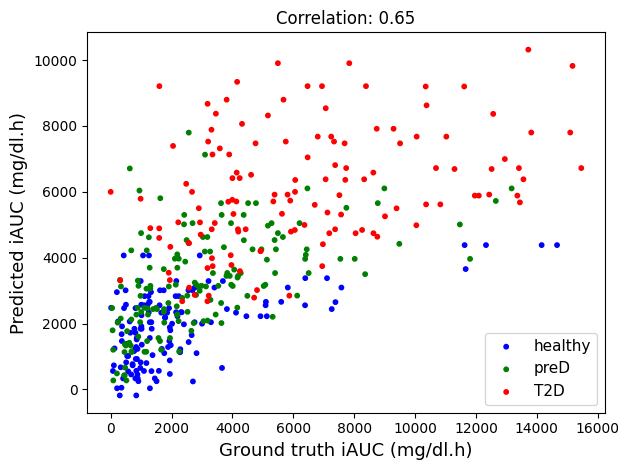

In [15]:
fontsize = 13

index = np.where(colors == "blue")[0]
plt.scatter(gt_array[index], pred_array[index], c=colors[index], s=10, label="healthy")

index = np.where(colors == "green")[0]
plt.scatter(gt_array[index], pred_array[index], c=colors[index], s=10, label="preD")

index = np.where(colors == "red")[0]
plt.scatter(gt_array[index], pred_array[index], c=colors[index], s=10, label="T2D")

plt.ylabel("Predicted iAUC (mg/dl.h)", fontsize=fontsize)
plt.xlabel("Ground truth iAUC (mg/dl.h)", fontsize=fontsize)
plt.title(f"Correlation: {round(scipy.stats.pearsonr(pred_array, gt_array)[0], 2)}")
plt.legend(fontsize=11)
plt.tight_layout()
# plt.savefig("corr_iAUC.svg", format='svg')

In [16]:
x = data_all_sub[['Carb', 'Protein', 'Fat', 'Fiber', 'Baseline_Libre', 'Age', 'Gender', 'BMI', 'A1c', 'HOMA', 'Insulin', 'TG', 'Cholesterol',
'HDL', 'Non HDL', 'LDL', 'VLDL', 'CHO/HDL ratio', 'Fasting BG']]

In [17]:
for col in x.columns:
    x[col] = zscore(x[col])

x = x.rename(columns={'insulin': 'Insulin', 'Baseline_Libre': 'Baseline gl.', 'non HDL': 'Non HDL', 'HOMA': 'HOMA-IR'})

C:\Users\Hal\AppData\Local\Temp\ipykernel_23540\1752514620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = zscore(x[col])
C:\Users\Hal\AppData\Local\Temp\ipykernel_23540\1752514620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = zscore(x[col])
C:\Users\Hal\AppData\Local\Temp\ipykernel_23540\1752514620.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

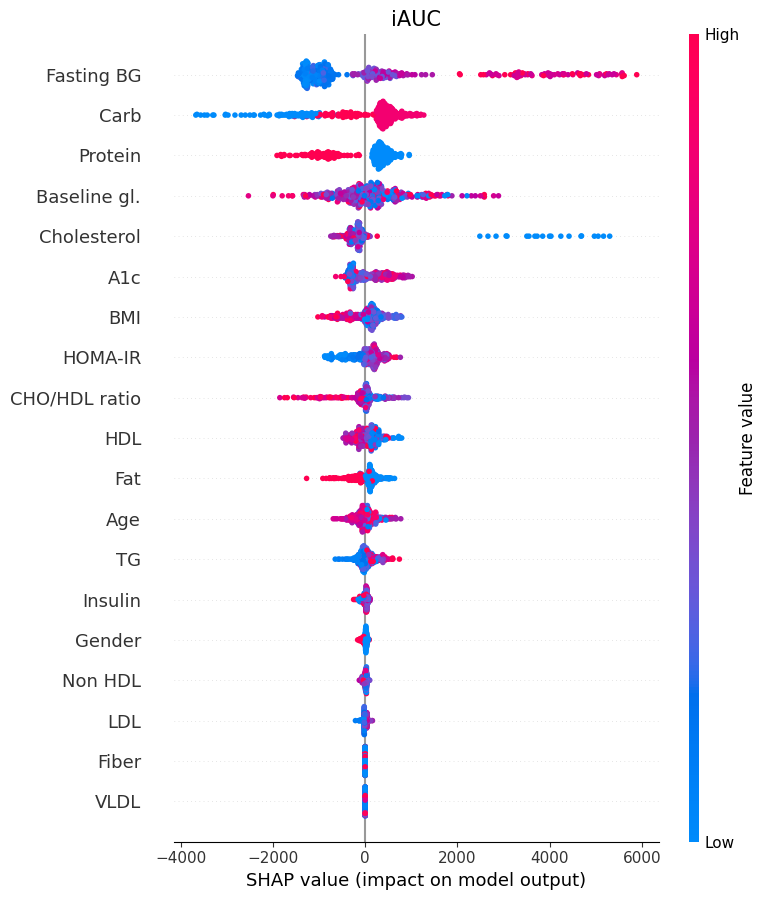

In [18]:
y_true = data_all_sub['iAUC']

mdl = xgb.XGBRegressor()
mdl.fit(x, y_true)
y_pred = mdl.predict(x)

exp = shap.TreeExplainer(mdl, x)

check_additivity=False
shap_values = exp.shap_values(x, check_additivity=check_additivity)

# shap.plots.bar(shap_values)
shap.summary_plot(shap_values, x, show=False)
plt.title("iAUC", fontsize=15)
plt.tight_layout()
plt.savefig("iAUC.svg")

In [44]:
x_data = data_all_sub[['sub', 'Carbs', 'Protein', 'Fat', 'Fiber', 'Baseline_Libre', 'Age', 'Gender', 'BMI', 'A1c', 'HOMA', 'Insulin', 'TG', 'Cholesterol',
'HDL', 'Non HDL', 'LDL', 'VLDL', 'CHO/HDL ratio', 'Fasting BG']]

In [45]:
gt_list = []
pred_list = []
colors = []
target = 'AUC'
for i, sub in enumerate(subjects):
    x_train = x_data[x_data["sub"] != sub].iloc[:, 1:]
    y_train = data_all_sub[data_all_sub["sub"] != sub][target]
    x_test = x_data[x_data["sub"] == sub].iloc[:, 1:]
    y_test = data_all_sub[data_all_sub["sub"] == sub][target]
    
    scaler = StandardScaler()
    x_train = scaler.fit_transform(x_train)
    x_test = scaler.transform(x_test)
    
    for j in range(len(x_test)):
        if a1c[i] < 5.7:
            colors.append('blue')
        elif a1c[i] >= 5.7 and a1c[i] <= 6.4:
            colors.append('green')
        else:
            colors.append('red')

    mdl = xgb.XGBRegressor(max_depth=1, n_estimators=80, learning_rate=0.2, reg_alpha=1, reg_lambda=0)
    mdl.fit(x_train, y_train)
    y_pred = mdl.predict(x_test)
    pred_list.append(y_pred)
    gt_list.append(y_test)
colors = np.array(colors)

pred_array, gt_array = np.concatenate(pred_list, axis=0), np.concatenate(gt_list, axis=0)
scipy.stats.pearsonr(pred_array, gt_array)

PearsonRResult(statistic=0.8854833630938073, pvalue=3.238880893838294e-142)

In [46]:
status = []
for color in colors:
    if color == "blue":
        status.append("healthy")
    elif color == "green":
        status.append("preD")
    elif color == "red":
        status.append("T2D")
    
len(status), len(colors)

(423, 423)

In [47]:
df = pd.DataFrame(list(zip(gt_array, pred_array, status)), columns=["ground truth", "prediction", "health status"])
df.to_csv("AUC.csv")

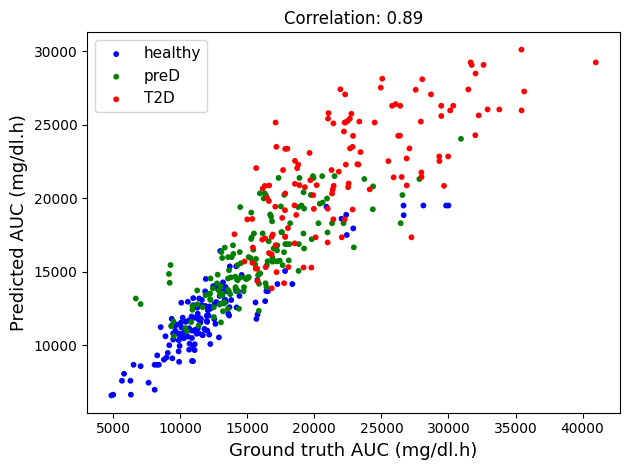

In [48]:
fontsize = 13
# plt.scatter(gt_array, pred_array)

index = np.where(colors == "blue")[0]
plt.scatter(gt_array[index], pred_array[index], c=colors[index], s=10, label="healthy")

index = np.where(colors == "green")[0]
plt.scatter(gt_array[index], pred_array[index], c=colors[index], s=10, label="preD")

index = np.where(colors == "red")[0]
plt.scatter(gt_array[index], pred_array[index], c=colors[index], s=10, label="T2D")

plt.ylabel("Predicted AUC (mg/dl.h)", fontsize=fontsize)
plt.xlabel("Ground truth AUC (mg/dl.h)", fontsize=fontsize)
plt.title(f"Correlation: {round(scipy.stats.pearsonr(pred_array, gt_array)[0], 2)}")
plt.legend(fontsize=11)
plt.tight_layout()

In [49]:
x = data_all_sub[['Carbs', 'Protein', 'Fat', 'Fiber', 'Baseline_Libre', 'Age', 'Gender', 'BMI', 'A1c', 'HOMA', 'Insulin', 'TG', 'Cholesterol',
'HDL', 'Non HDL', 'LDL', 'VLDL', 'CHO/HDL ratio', 'Fasting BG']]

In [50]:
for col in x.columns:
    x[col] = zscore(x[col])

x = x.rename(columns={'Baseline_Libre': 'Baseline gl.', 'HOMA': 'HOMA-IR'})

C:\Users\Hal\AppData\Local\Temp\ipykernel_23656\2091119937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = zscore(x[col])
C:\Users\Hal\AppData\Local\Temp\ipykernel_23656\2091119937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x[col] = zscore(x[col])
C:\Users\Hal\AppData\Local\Temp\ipykernel_23656\2091119937.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

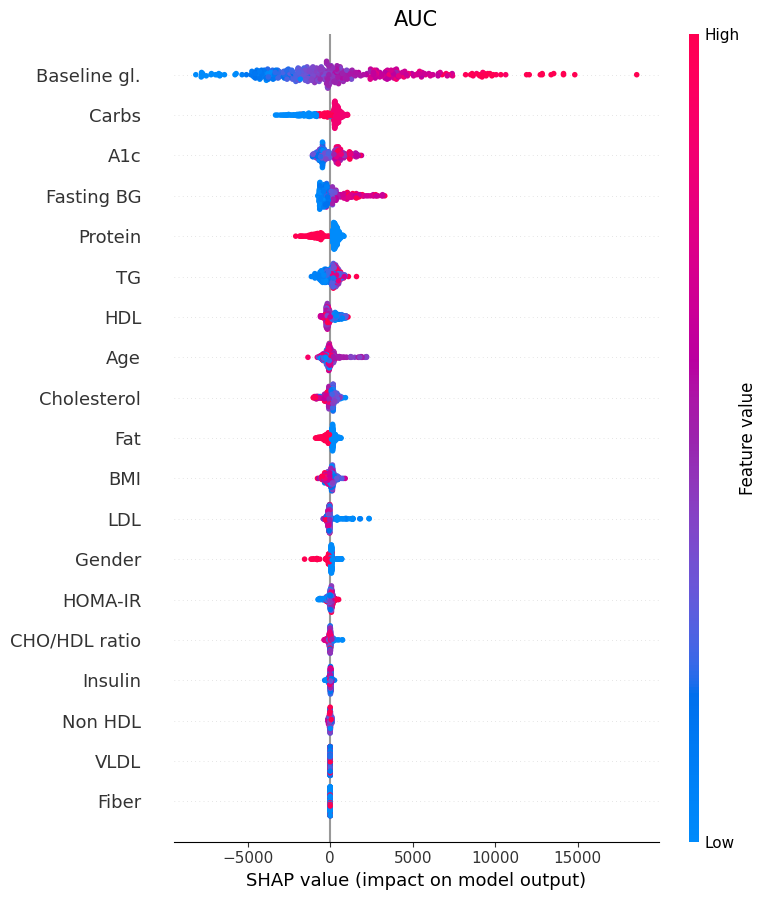

In [51]:
y_true = data_all_sub['AUC']

mdl = xgb.XGBRegressor()
# mdl = RandomForestRegressor()
mdl.fit(x, y_true)
y_pred = mdl.predict(x)

exp = shap.TreeExplainer(mdl, x)

check_additivity=False
shap_values = exp.shap_values(x, check_additivity=check_additivity)

# shap.plots.bar(shap_values)
shap.summary_plot(shap_values, x, show=False)
plt.title("AUC", fontsize=15)
plt.tight_layout()
plt.savefig("AUC.svg")